<a href="https://colab.research.google.com/github/sonalshreya25/respiratoryDiagnostic/blob/dev/Copy_of_ICBHI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Mount Google Drive**

This code mounts my Google Drive into the Colab environment so I can read and write files directly — including loading audio data, saving spectrograms, and storing Grad-CAM visualizations.

Once I run this cell, I’ll be prompted to authenticate with my Google account. After authentication, my Drive becomes available at the path `/content/drive/`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Step 2: Set Paths**

This block imports the required Python libraries for file handling, data processing, audio loading, and visualization.

It also defines paths to important files and folders located in Google Drive, including:
- `root_dir`: the base directory of the ICBHI dataset
- `audio_dir`: folder containing the `.wav` recordings and annotation files
- `diagnosis_file`: contains patient IDs and their diagnosis labels
- `train_patients_file` and `test_patients_file`: define which patients belong to the training and testing sets
- `train_test_file`: contains train/test split information at the recording level
- `events_folder`: includes event-level annotations (e.g., wheezes and crackles)


In [ ]:
# STEP 2: Set Paths
import os
import pandas as pd
from glob import glob
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Change this to your Google Drive path
root_dir = "/content/drive/MyDrive/ICBHI_final_database"
audio_dir = os.path.join(root_dir, "recordings_annotations")
diagnosis_file = os.path.join(root_dir, "diagnosis_data.txt")
train_patients_file = os.path.join(root_dir, "train_data.txt")
test_patients_file = os.path.join(root_dir, "test_data.txt")
train_test_file = os.path.join(root_dir, "train_test_data.txt")
events_folder = os.path.join(root_dir, "events/events")


# **Step 3: Load Diagnosis and Patient Split Data**

This block loads important metadata required to organize and label the dataset:

- The `diagnosis_df` DataFrame reads patient diagnosis information from `diagnosis_data.txt`, which includes a patient ID and their corresponding label (diagnosis class).
- Patient IDs are converted to string type to ensure consistent matching later.

Next, the training and testing patient splits are read from `train_data.txt` and `test_data.txt`, respectively. These lists help assign each recording to the correct dataset partition for model training and evaluation.


In [ ]:
# STEP 3: Load diagnosis and patient split data
diagnosis_df = pd.read_csv(diagnosis_file, header=None, sep='\t', names=['Patient_ID', 'Diagnosis'])
diagnosis_df['Patient_ID'] = diagnosis_df['Patient_ID'].astype(str)

with open(train_patients_file, 'r') as f:
    train_patients = [line.strip() for line in f.readlines()]

with open(test_patients_file, 'r') as f:
    test_patients = [line.strip() for line in f.readlines()]


# **Step 4: Scan Audio and Annotation Files**

This step scans through all the `.wav` audio recordings and their corresponding `.txt` annotation files in the dataset.

For each audio file:
- The patient ID is extracted from the filename.
- It checks if the corresponding annotation file exists.
- The patient’s diagnosis is retrieved using their ID.
- The file is categorized as part of the train/test/unknown split based on the patient ID.

All relevant metadata — such as patient ID, file name, full paths, diagnosis, and dataset split — is compiled into a dictionary and appended to a list.

Finally, the list is converted into a `pandas` DataFrame (`df`) that serves as the master reference table for the dataset.


In [ ]:
#STEP 4: Scan all audio + annotation files
data = []

for wav_file in tqdm(glob(os.path.join(audio_dir, "*.wav"))):
    base_name = os.path.basename(wav_file)
    patient_id = base_name.split('_')[0]
    txt_file = wav_file.replace(".wav", ".txt")

    if not os.path.exists(txt_file):
        continue

    diagnosis = diagnosis_df.loc[diagnosis_df['Patient_ID'] == patient_id, 'Diagnosis']
    diagnosis = diagnosis.values[0] if not diagnosis.empty else None

    if patient_id in train_patients:
        split = 'train'
    elif patient_id in test_patients:
        split = 'test'
    else:
        split = 'unknown'

    data.append({
        'Patient_ID': patient_id,
        'File': base_name,
        'WAV_Path': wav_file,
        'TXT_Path': txt_file,
        'Diagnosis': diagnosis,
        'Split': split
    })

df = pd.DataFrame(data)


100%|██████████| 920/920 [00:00<00:00, 1400.89it/s]


# **Step 5: Extract Crackle and Wheeze Events from Annotation Files**

This step processes the event-level annotation files to identify whether each recording contains audible crackles and/or wheezes.

- The function `extract_events` builds the path to each recording’s corresponding `_events.txt` file.
- It checks for the presence of the words "crackle" or "wheeze" (case-insensitive) in the file.
- If found, it sets binary flags `has_crackle` and `has_wheeze` accordingly.

These values are applied to every file listed in the DataFrame, and two new columns — `Crackles` and `Wheezes` — are added to indicate the presence of these features.


In [ ]:
# STEP 5: Extract crackle and wheeze events from event files
def extract_events(file_name):
    base_name = os.path.splitext(file_name)[0]
    events_file = os.path.join(events_folder, base_name + '_events.txt')
    has_crackle, has_wheeze = 0, 0
    try:
        with open(events_file, 'r') as f:
            for line in f:
                if 'crackle' in line.lower():
                    has_crackle = 1
                if 'wheeze' in line.lower():
                    has_wheeze = 1
    except FileNotFoundError:
        pass
    return pd.Series([has_crackle, has_wheeze])

df[['Crackles', 'Wheezes']] = df['File'].apply(extract_events)


# **Step 6: Merge Refined Train/Test Split from File**

This step updates the train/test split information in the main DataFrame using a refined version of the split provided in `train_test_data.txt`.

- The file is loaded into a DataFrame with columns `FileBase` (base filename) and `Split` (either `train` or `test`).
- A new `File` column is created by appending `.wav` to match the filenames in the main DataFrame.
- The old `Split` column is dropped from the main DataFrame to avoid conflict.
- A merge is performed to update the split labels based on the actual file names.
- Any files that were not found in the split file are assigned the split label `unknown`.

This ensures that every audio file is now properly assigned to the training, testing, or unknown group.


In [ ]:
# STEP 6: Merge refined train/test data from shared file
split_df = pd.read_csv(
    train_test_file,
    sep='\t',
    header=None,
    names=['FileBase', 'Split']
)
split_df['File'] = split_df['FileBase'] + '.wav'
split_df.drop(columns='FileBase', inplace=True)

df = df.drop(columns=['Split'])  # Remove old one
df = df.merge(split_df, on='File', how='left')
df['Split'] = df['Split'].fillna('unknown')


# **Step 7: Display the Final DataFrame**

This step displays the final shape and a preview of the constructed DataFrame (`df`).

By this point, the DataFrame includes:
- File-level metadata (e.g., filename, paths)
- Patient-level information (e.g., diagnosis)
- Audio event features (`Crackles`, `Wheezes`)
- The final `Split` column indicating whether each file belongs to the training, testing, or unknown set

This serves as the master reference table that will be used throughout the preprocessing and model training pipeline.


In [ ]:
# STEP 7: Display the final DataFrame
print(" Final DataFrame shape:", df.shape)
df.head()


 Final DataFrame shape: (920, 8)


,Patient_ID,File,WAV_Path,TXT_Path,Diagnosis,Crackles,Wheezes,Split
0,160,160_1b3_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,test
1,160,160_1b4_Ar_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
2,158,158_1p4_Tc_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,0,1,train
3,160,160_1b3_Al_mc_AKGC417L.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,COPD,1,1,test
4,159,159_1b1_Ll_sc_Meditron.wav,/content/drive/MyDrive/ICBHI_final_database/re...,/content/drive/MyDrive/ICBHI_final_database/re...,Healthy,0,0,train


# **Step 8: Generate and Save Spectrograms**

This step defines a helper function to generate both `.npy` and `.png` spectrograms from audio recordings.

- The `generate_and_save_spectrogram()` function loads an audio file using `librosa`, computes its Short-Time Fourier Transform (STFT), and converts it into decibel scale.
- The decibel spectrogram is normalized and saved as a `.npy` file — this will be used as input for model training.
- A visual version of the spectrogram is also created and saved as a `.png` image for use in visualizations and Grad-CAM++ overlays.

All generated files are stored in a folder called `spectrograms` inside the dataset root directory.


In [ ]:
#Step 8
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Create output folder
output_dir = os.path.join(root_dir, "spectrograms")
os.makedirs(output_dir, exist_ok=True)

# Spectrogram helper
def generate_and_save_spectrogram(wav_path, file_name, duration=3, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # STFT + dB conversion
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Normalize for training (.npy)
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # Save .npy
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # Save .png
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return npy_path, png_path


# **Step 9 : Batch Generate Spectrograms**

This loop iterates over each row in the main DataFrame and generates spectrograms for each `.wav` file using the previously defined `generate_and_save_spectrogram()` function.

- For each audio file, it checks if the corresponding `.npy` and `.png` spectrograms already exist. If they do, it skips regeneration and simply records the paths in the DataFrame.
- If the spectrograms do not exist, it generates them and stores their paths (`Spectrogram_Array` and `Spectrogram_Image`) in new columns in the DataFrame.
- Any errors during processing are caught and logged with a warning message.

This step ensures that spectrograms are created once, stored efficiently, and reused for both training and visualization.


In [ ]:
#Step 9
for idx, row in tqdm(df.iterrows(), total=len(df)):
    npy_path = os.path.join(output_dir, row['File'].replace('.wav', '.npy'))
    png_path = os.path.join(output_dir, row['File'].replace('.wav', '.png'))

    # Skip if both files already exist
    if os.path.exists(npy_path) and os.path.exists(png_path):
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
        continue

    try:
        npy_path, png_path = generate_and_save_spectrogram(row['WAV_Path'], row['File'])
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
    except Exception as e:
        print(f"Failed to process {row['File']}: {e}")


100%|██████████| 920/920 [00:05<00:00, 168.03it/s]


# **Step 10: Save DataFrame with Spectrogram Paths**

After generating spectrograms for all audio files, this step saves the updated DataFrame (`df`) as a `.pkl` file (`df_with_spectrograms.pkl`) in the project root directory.

The saved DataFrame includes:
- Original metadata (file paths, labels, split info, etc.)
- New columns pointing to the saved `.npy` and `.png` spectrograms

This serialized file can be loaded later to skip the entire preprocessing step and go straight into training or visualization.


In [ ]:
#Step 10
df.to_pickle(os.path.join(root_dir, "df_with_spectrograms.pkl"))
print("Saved metadata with spectrogram paths.")


Saved metadata with spectrogram paths.


# **Step 11: Filter Data, Encode Labels, and Visualize Distribution**

This step prepares the dataset for model training by performing the following tasks:

- **Filtering**: It removes any entries labeled as `'unknown'` in the `Split` column, keeping only those explicitly assigned to either the training or test set.

- **Label Encoding**: Uses `LabelEncoder` from `sklearn` to convert diagnosis labels (strings) into numerical class IDs, which are required for training a classification model. The result is stored in a new column called `EncodedLabel`.

- **Class Overview**: Prints the list of unique diagnosis classes in encoded form and stores the total number of classes for use in the model setup.

- **Visualization**: A bar plot is generated to show the distribution of diagnosis labels across training and test sets. This helps verify that the classes are somewhat balanced and that the dataset split is reasonable.


Total valid samples after filtering: 919
Encoded Classes: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


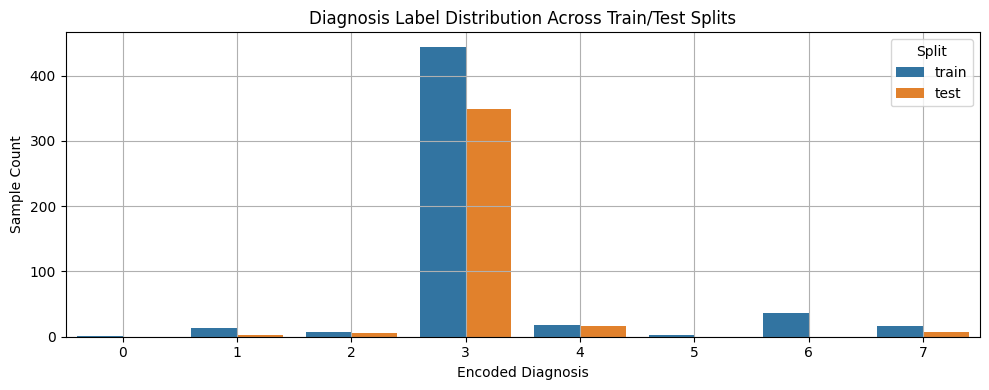

In [ ]:
#Step 11
# Skip 'unknown' patients
df = df[df['Split'].isin(['train', 'test'])].reset_index(drop=True)
print(f"Total valid samples after filtering: {df.shape[0]}")

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Diagnosis'].astype(str))

# Show label mapping
print("Encoded Classes:", list(label_encoder.classes_))
num_classes = len(label_encoder.classes_)

# Visualize label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.countplot(x='EncodedLabel', hue='Split', data=df)
plt.title("Diagnosis Label Distribution Across Train/Test Splits")
plt.xlabel("Encoded Diagnosis")
plt.ylabel("Sample Count")
plt.legend(title='Split')
plt.grid(True)
plt.tight_layout()
plt.show()


# **Step 12: Split into Train/Test Sets and Save**

This step separates the full dataset into two DataFrames:
- `train_df`: contains only samples marked as part of the training set
- `test_df`: contains only samples marked for testing

To support reproducibility and efficient reloading later, both splits are saved as `.pkl` (pickle) files:
- `train_split.pkl`
- `test_split.pkl`

These files can be loaded in future sessions to skip reprocessing and directly begin model training or evaluation.


In [ ]:
#Step 12
# Split into train/test DataFrames
train_df = df[df['Split'] == 'train'].reset_index(drop=True)
test_df = df[df['Split'] == 'test'].reset_index(drop=True)

# Save to .pkl for reproducibility
train_split_path = os.path.join(root_dir, "train_split.pkl")
test_split_path = os.path.join(root_dir, "test_split.pkl")

train_df.to_pickle(train_split_path)
test_df.to_pickle(test_split_path)

print(f"Train split saved to: {train_split_path}")
print(f"Test split saved to: {test_split_path}")


Train split saved to: /content/drive/MyDrive/ICBHI_final_database/train_split.pkl
Test split saved to: /content/drive/MyDrive/ICBHI_final_database/test_split.pkl


# **Step 13: Reload Train and Test Split Data**

This step reloads the previously saved `train_df` and `test_df` DataFrames from their `.pkl` files.  
It ensures that the dataset splits are preserved across notebook sessions without needing to repeat earlier preprocessing steps.

After loading, it prints the shapes of both datasets to confirm successful reloading.


In [ ]:
#Step 13
# Reload split data
train_df = pd.read_pickle(train_split_path)
test_df = pd.read_pickle(test_split_path)

print(f"Reloaded: Train shape {train_df.shape}, Test shape {test_df.shape}")


Reloaded: Train shape (538, 11), Test shape (381, 11)


# **Step 14: Filter Out Invalid Spectrograms**

This step ensures data consistency by verifying the shape of each `.npy` spectrogram file.

- It loops through both `train_df` and `test_df`, attempting to load each `.npy` file stored in the `Spectrogram_Array` column.
- It checks whether the spectrogram has the expected number of frequency bins (`1025`). This shape is required by the model.
- Only valid spectrograms with the correct shape are retained. Invalid or corrupt entries are skipped.

The filtered DataFrames are then reset and their new sizes are printed. This step prevents shape mismatch errors during model training.


In [ ]:
#Step 14
valid_indices = []

for i in range(len(train_df)):
    try:
        spec = np.load(train_df.loc[i, 'Spectrogram_Array'])
        if spec.shape[0] == 1025:  # Expected freq bins
            valid_indices.append(i)
    except:
        continue

train_df = train_df.loc[valid_indices].reset_index(drop=True)
print(f"Filtered train set: {len(train_df)} samples")

valid_indices = []
for i in range(len(test_df)):
    try:
        spec = np.load(test_df.loc[i, 'Spectrogram_Array'])
        if spec.shape[0] == 1025:
            valid_indices.append(i)
    except:
        continue

test_df = test_df.loc[valid_indices].reset_index(drop=True)
print(f"Filtered test set: {len(test_df)} samples")


Filtered train set: 538 samples
Filtered test set: 381 samples


# **Step 15: Define Custom Dataset Class with Fixed Input Shape**

This step defines a PyTorch `Dataset` class named `ICBHI_1D_CNN_Dataset` that handles loading and preparing spectrogram data for the model.

Key features of the class:
- Loads the `.npy` spectrogram file for each sample.
- Ensures each spectrogram has a consistent shape of `[1025, 256]` by padding or truncating both frequency and time dimensions.
- Handles missing or corrupt files by substituting a zero-filled placeholder.
- Converts the spectrogram into a PyTorch tensor (`x`) and pairs it with its corresponding encoded label (`y`).

This preprocessing guarantees that all model inputs are uniform in size, which is essential for batch training in neural networks.


In [ ]:
#Step 15
# Dataset class that guarantees fixed shape [1025, 256]
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ICBHI_1D_CNN_Dataset(Dataset):
    def __init__(self, df_subset, max_len=256, expected_freq=1025):
        self.data = df_subset.reset_index(drop=True)
        self.max_len = max_len
        self.expected_freq = expected_freq

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx]
        try:
            spectrogram = np.load(row['Spectrogram_Array'])  # [freq, time]
        except:
            spectrogram = np.zeros((self.expected_freq, self.max_len))

        if len(spectrogram.shape) != 2:
            spectrogram = np.zeros((self.expected_freq, self.max_len))

        freq, time = spectrogram.shape

        # Pad/truncate freq axis
        if freq < self.expected_freq:
            spectrogram = np.pad(spectrogram, ((0, self.expected_freq - freq), (0, 0)), mode='constant')
        elif freq > self.expected_freq:
            spectrogram = spectrogram[:self.expected_freq, :]

        # Pad/truncate time axis
        if time < self.max_len:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, self.max_len - time)), mode='constant')
        elif time > self.max_len:
            spectrogram = spectrogram[:, :self.max_len]

        x = torch.tensor(spectrogram, dtype=torch.float32)
        y = torch.tensor(row['EncodedLabel'], dtype=torch.long)
        return x, y


# **Step 16: Create Datasets and DataLoaders**

This step creates the actual PyTorch dataset and dataloader objects used for model training and evaluation.

- `train_ds` and `test_ds` are instances of the custom `ICBHI_1D_CNN_Dataset`, configured to return spectrograms of fixed shape `[1025, 256]`.
- A quick check (`x0.shape`) confirms the shape of one sample from the training set.
- `train_loader` and `test_loader` wrap the datasets into batches of 32 samples and enable iteration over them in training and testing loops.

These DataLoaders are now ready to feed data efficiently to the model during training.


In [ ]:
#Step 16
# Build datasets and dataloaders
train_ds = ICBHI_1D_CNN_Dataset(train_df, max_len=256)
test_ds = ICBHI_1D_CNN_Dataset(test_df, max_len=256)

# Quick sanity check
x0, y0 = train_ds[0]
print("Example shape:", x0.shape)  # should be [1025, 256]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)
print("Dataloaders ready")




Example shape: torch.Size([1025, 256])
Dataloaders ready


# **Step 17: Define the ResNet1D Model**

This block defines the architecture of a custom 1D Convolutional Neural Network based on residual connections (ResNet) to classify spectrogram inputs.

- **ResidualBlock1D**: A building block that uses skip connections to allow gradients to flow more effectively through deeper layers.
  - It applies two 1D convolution layers with batch normalization and optional downsampling.
  - If input and output dimensions differ, a downsampling path ensures the shapes match before residual addition.

- **ResNet1D**: The full model composed of three residual blocks:
  - It increases channel depth across layers (32 → 64 → 128) while reducing temporal dimensions.
  - An adaptive average pooling layer reduces the temporal dimension to 1.
  - A fully connected (`Linear`) layer maps the final feature vector to the number of output classes.

This model is well-suited for processing time-series features extracted from spectrograms.


In [ ]:
#Step 17
# Define ResNet1D model
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 1, stride=stride),
            nn.BatchNorm1d(out_channels)
        ) if downsample or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + identity)

class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer1 = ResidualBlock1D(in_channels, 32)
        self.layer2 = ResidualBlock1D(32, 64, downsample=True)
        self.layer3 = ResidualBlock1D(64, 128, downsample=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


# **Step 18: Train the ResNet1D Model**

This block performs the training and evaluation loop for the `ResNet1D` model.

- **Device Setup**: Automatically selects GPU (`cuda`) if available, otherwise falls back to CPU.
- **Model Initialization**:
  - The model is instantiated with the correct number of input channels and classes.
  - Uses `CrossEntropyLoss` for multi-class classification.
  - The `Adam` optimizer is used with a learning rate of 1e-3.

- **Training Loop**:
  - For each epoch (10 total), the model is trained on batches from the `train_loader`.
  - Gradients are calculated, and weights are updated using backpropagation.

- **Evaluation**:
  - After each epoch, the model is evaluated on the test set.
  - Predictions are compared to ground-truth labels using `accuracy_score` from `sklearn`.

- **Output**: For each epoch, the loop prints the training loss and accuracy on the test set.

This step trains the CNN to recognize lung sound patterns using time-frequency features from the spectrograms.


In [ ]:
#Step 18
# Train the model
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['EncodedLabel'].unique())
input_channels = x0.shape[0]

model = ResNet1D(input_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")


Epoch 1 | Loss: 18.0313 | Accuracy: 0.9160
Epoch 2 | Loss: 9.0692 | Accuracy: 0.9160
Epoch 3 | Loss: 7.7011 | Accuracy: 0.9186
Epoch 4 | Loss: 7.1977 | Accuracy: 0.9265
Epoch 5 | Loss: 6.3472 | Accuracy: 0.9239
Epoch 6 | Loss: 7.1477 | Accuracy: 0.7979
Epoch 7 | Loss: 6.2567 | Accuracy: 0.8556
Epoch 8 | Loss: 5.5197 | Accuracy: 0.9344
Epoch 9 | Loss: 5.5352 | Accuracy: 0.9003
Epoch 10 | Loss: 5.3143 | Accuracy: 0.9396


# **Step 19: Save the Trained Model**

After training is complete, this step saves the learned model weights to a file named `resnet1d_icbhi.pth`.

- This file contains only the parameters (`state_dict`) of the trained `ResNet1D` model.
- Saving the model allows for easy reuse later — for example, to reload the model for inference, evaluation, or Grad-CAM visualization without retraining.

The file can be stored locally or uploaded to Google Drive for long-term access.


In [ ]:
#Step 19
torch.save(model.state_dict(), "resnet1d_icbhi.pth")


# **Step 20: Plot the Confusion Matrix**

This step evaluates the model's classification performance using a confusion matrix.

- It uses `confusion_matrix` from `sklearn.metrics` to compute a matrix comparing predicted vs. actual labels.
- `ConfusionMatrixDisplay` is used to visualize the matrix as a heatmap with readable axis labels.
- The matrix shows how well the model performs across each diagnosis class, helping to identify misclassifications or class imbalances.

This visual diagnostic tool is especially useful for medical audio datasets, where distinguishing between conditions is critical.


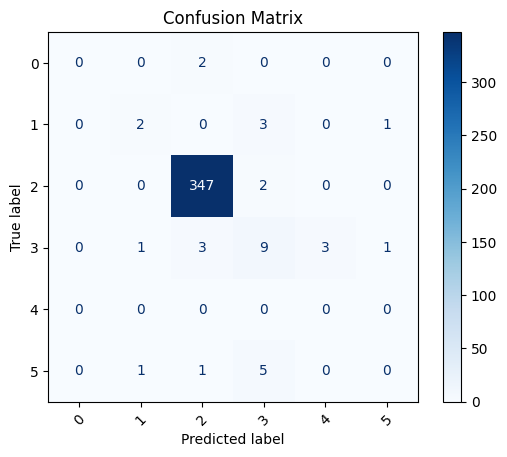

In [ ]:
#Step 20
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()



# **Step 21: Stratified K-Fold Cross-Validation**

This step sets up 5-fold stratified cross-validation to assess the model’s robustness and generalizability.

- `StratifiedKFold` ensures each fold maintains the original class distribution (important for imbalanced datasets like ICBHI).
- The data is split into 5 train/validation partitions, and each fold is used once as a validation set while the rest form the training set.
- For each fold:
  - It creates a training and validation DataFrame.
  - These are wrapped into PyTorch datasets and DataLoaders using the same `ICBHI_1D_CNN_Dataset` class.
  - The model can then be trained on the training loader and evaluated on the validation loader.

This setup helps ensure that model performance is not overly dependent on a single train/test split and gives a better estimate of real-world generalization.


In [ ]:
#Step 21
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_df['Spectrogram_Array'].values
y = train_df['EncodedLabel'].values

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")

    fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)

    train_ds = ICBHI_1D_CNN_Dataset(fold_train_df)
    val_ds = ICBHI_1D_CNN_Dataset(fold_val_df)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)




Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# **Step 22: Visualize Grad-CAM++ Activation for a Single Prediction**

This step uses Grad-CAM++ to visualize which parts of the spectrogram the trained model focused on when making its prediction.

- **Input Selection**: A sample input is taken from the training set and sent through the model (note: no `torch.no_grad()` here, as Grad-CAM++ requires gradients).
- **Grad-CAM++ Setup**:
  - `GradCAMpp` is initialized from the `torchcam` library.
  - The method hooks into the model’s final residual layer (`layer3`) to extract feature importance.
- **Prediction and Visualization**:
  - The predicted class is obtained via `argmax`.
  - An activation map is generated that highlights important time–frequency regions influencing the decision.
  - The map is visualized using `matplotlib`, showing areas with the strongest influence (red = higher activation).

This visualization helps interpret and validate how the model makes decisions — especially important in medical applications.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

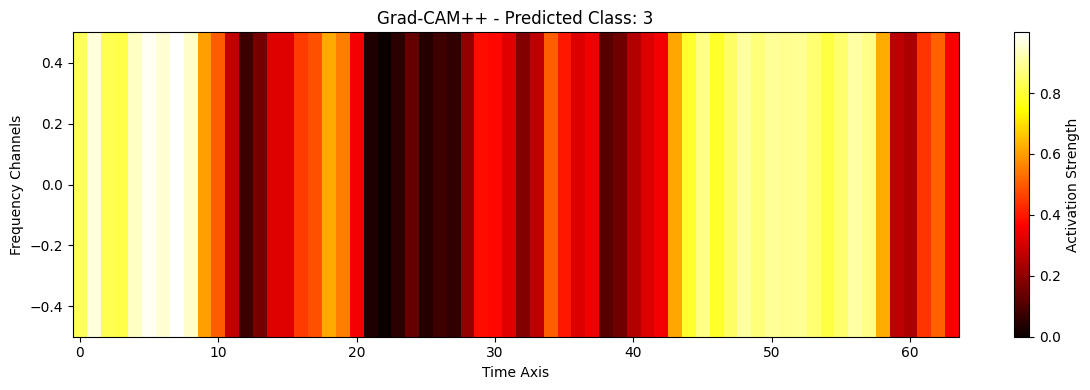

In [ ]:
  #Step 22
  # Get input
  !pip install torchcam
  input_tensor, label = train_ds[0]
  input_tensor = input_tensor.unsqueeze(0).to(device)

  # Grad-CAM++ setup
  from torchcam.methods import GradCAMpp
  cam_extractor = GradCAMpp(model, target_layer="layer3")

  # Forward pass (no torch.no_grad())
  model.eval()
  output = model(input_tensor)

  # Get activation map
  predicted_class = output.argmax(dim=1).item()
  activation_map = cam_extractor(predicted_class, output)[0].cpu()

  # Plot
  import matplotlib.pyplot as plt
  plt.figure(figsize=(12, 4))
  plt.imshow(activation_map, aspect='auto', origin='lower', cmap='hot')
  plt.colorbar(label="Activation Strength")
  plt.title(f"Grad-CAM++ - Predicted Class: {predicted_class}")
  plt.xlabel("Time Axis")
  plt.ylabel("Frequency Channels")
  plt.tight_layout()
  plt.show()


# **Step 23: Batch Grad-CAM++ Overlays with Spectrograms**

This step generates and saves Grad-CAM++ activation overlays for multiple training samples, helping visualize what the model focuses on across different predictions.

- **Directory Setup**: A new folder (`gradcam_outputs`) is created to store the output `.png` files.
- **Grad-CAM++ Activation**:
  - The `GradCAMpp` method is used to extract class-discriminative activation maps from the final convolutional layer of the model.
- **Visualization Loop**:
  - For each sample:
    - The model makes a prediction.
    - The Grad-CAM++ heatmap is generated for the predicted class.
    - The heatmap is resized and overlaid on the original spectrogram.
    - The figure is saved as a `.png` file with its predicted and true class labels in the filename.

This provides an interpretable, visual explanation of the model’s decisions for several training samples.


In [ ]:
#step 23
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchcam.methods import GradCAMpp

# Create directory to save Grad-CAM++ visual outputs
save_dir = "gradcam_outputs"
os.makedirs(save_dir, exist_ok=True)

# Set up Grad-CAM++ extractor on the final conv layer
cam_extractor = GradCAMpp(model, target_layer="layer3")
model.eval()

# Loop over first N samples from the dataset
N = 5  # Change this to however many samples you want
for idx in range(N):
    # Load one sample
    input_tensor, label = train_ds[idx]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dim

    # Forward pass
    output = model(input_tensor)

    # Predicted class
    predicted_class = output.argmax(dim=1).item()

    # Get activation map
    activation_map = cam_extractor(predicted_class, output)[0].cpu().numpy()

    # Original spectrogram
    original_spec = input_tensor.squeeze(0).cpu().numpy()

    # Normalize activation map
    act_resized = np.interp(activation_map, (activation_map.min(), activation_map.max()), (0, 1))

    # Plot: Overlay CAM on spectrogram
    plt.figure(figsize=(12, 4))
    plt.imshow(original_spec, aspect='auto', origin='lower', cmap='gray')
    plt.imshow(act_resized, aspect='auto', origin='lower', cmap='hot', alpha=0.4)
    plt.colorbar(label="Activation Strength")
    plt.title(f"Grad-CAM++ Overlay | Pred: {predicted_class} | True: {label}")
    plt.xlabel("Time Axis")
    plt.ylabel("Frequency Channels")
    plt.tight_layout()

    # Save the figure
    out_path = os.path.join(save_dir, f"gradcam_{idx}_pred{predicted_class}_true{label}.png")
    plt.savefig(out_path)
    plt.close()

print(f"Saved Grad-CAM++ overlays for {N} samples to: {save_dir}")


Saved Grad-CAM++ overlays for 5 samples to: gradcam_outputs


# **Step 24: Save Side-by-Side Grad-CAM++ Comparisons for Correct vs. Incorrect Predictions**

This block automates the generation of Grad-CAM++ overlays for model predictions and saves them into separate folders based on prediction correctness.

- **Grad-CAM++ Setup**: A `GradCAMpp` extractor is created on the final residual layer of the model.
- **Folder Management**:
  - `gradcam_correct/`: stores overlays where the predicted class matches the true label.
  - `gradcam_incorrect/`: stores overlays where the model predicted the wrong class.
- **Visualization Process**:
  - Loads the `.png` spectrogram image for each training sample.
  - Extracts the attention map and resizes it to match the original spectrogram.
  - Creates a heatmap and blends it with the original image to highlight important regions.
  - Saves a side-by-side visualization (original vs. overlay) to the appropriate folder.

- **Drive Integration**:
  - All overlays are saved to a designated Google Drive folder (`/content/drive/MyDrive/ICBHI_GradCAM`).
  - The folders for correct and incorrect predictions are zipped and saved in Drive for download or sharing.

This step adds powerful interpretability to the model by visually showing where it’s focusing for both successful and failed predictions.


In [ ]:
#Step 24
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchcam.methods import GradCAMpp
from PIL import Image

# Grad-CAM++ setup
cam_extractor = GradCAMpp(model, target_layer="layer3")
model.eval()

# Output folders
correct_dir = "gradcam_correct"
incorrect_dir = "gradcam_incorrect"
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# Loop through training set
N = 20  # You can increase this
for idx in range(N):
    # Load spectrogram from Dataset
    input_tensor, label = train_ds[idx]
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Predict and extract attention
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    activation_map = cam_extractor(pred_class, output)[0].cpu().numpy()

    # Locate corresponding PNG file
    npy_path = train_df.loc[idx, 'Spectrogram_Array']
    png_path = npy_path.replace(".npy", ".png")
    if not os.path.exists(png_path):
        print(f"Missing PNG: {png_path}")
        continue

    # Load image and overlay attention
    spec_img = Image.open(png_path).convert("RGB")
    spec_array = np.array(spec_img)

    # Normalize and resize activation map
    activation_map_resized = np.interp(activation_map, (activation_map.min(), activation_map.max()), (0, 1))
    heatmap = plt.cm.jet(activation_map_resized)[:, :, :3]  # RGB colormap
    heatmap_img = Image.fromarray(np.uint8(heatmap * 255)).resize(spec_img.size)

    # Blend with original
    overlay = Image.blend(spec_img, heatmap_img, alpha=0.5)

    # Side-by-side comparison
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].imshow(spec_img)
    axs[0].set_title("Original Spectrogram")
    axs[0].axis("off")

    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM++ Overlay | Pred: {pred_class} | True: {label}")
    axs[1].axis("off")

    # Save to correct/incorrect folders
    plt.tight_layout()
    folder = correct_dir if pred_class == label else incorrect_dir
    out_path = os.path.join(folder, f"cam_{idx}_pred{pred_class}_true{label}.png")
    plt.savefig(out_path)
    plt.close()

print(f"All Grad-CAM++ overlays saved to '{correct_dir}' and '{incorrect_dir}'")
# Google Drive path (change this to any folder you want inside your Drive)
base_dir = "/content/drive/MyDrive/ICBHI_GradCAM"

correct_dir = os.path.join(base_dir, "gradcam_correct")
incorrect_dir = os.path.join(base_dir, "gradcam_incorrect")

os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)
!zip -r /content/drive/MyDrive/ICBHI_GradCAM_correct.zip /content/drive/MyDrive/ICBHI_GradCAM/gradcam_correct
!zip -r /content/drive/MyDrive/ICBHI_GradCAM_incorrect.zip /content/drive/MyDrive/ICBHI_GradCAM/gradcam_incorrect


All Grad-CAM++ overlays saved to 'gradcam_correct' and 'gradcam_incorrect'
updating: content/drive/MyDrive/ICBHI_GradCAM/gradcam_correct/ (stored 0%)
updating: content/drive/MyDrive/ICBHI_GradCAM/gradcam_incorrect/ (stored 0%)
